### import gym 
gym.version.VERSION

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from gridworld_env import GridworldEnv

In [2]:
env = GridworldEnv('') # Number of plan 

/Users/samueloliveira/opt/anaconda3/envs/maai-env/lib/python3.12/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


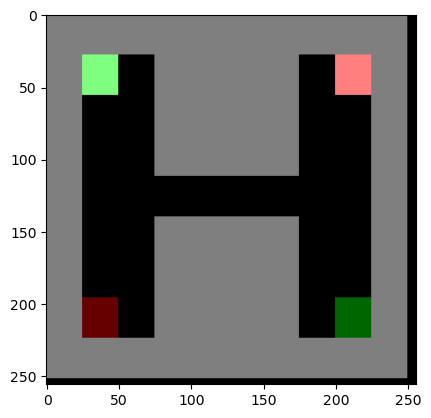

In [3]:
env.render()

In [4]:
env.observation_space

Box(-1.0, [8. 9. 5. 1. 8. 9. 5. 1.], (8,), float32)

In [5]:
print(env.reset())
#print(env.action_space.sample())
env.step([env.action_space[0].sample(),env.action_space[1].sample()])
#env.step(env.action_space.sample())

[1, 1, 0.0, 0.0, 1, 8, 0.0, 0.0]


(array([1, 1, 0, 0, 1, 8, 0, 0]), [0.0, 0.0], [False, False])

In [6]:
env.verbose = True
print( env._get_agents_start_target_state())

((1, 1), (7, 8), (1, 8), (7, 1))


In [7]:
env.grid_map_shape

(9, 10)

In [8]:
env.observation_space

Box(-1.0, [8. 9. 5. 1. 8. 9. 5. 1.], (8,), float32)

In [9]:
env.action_space

{0: Discrete(5), 1: Discrete(5)}

State 				 - Reward
[1 1 0 0 1 8 2 0] 			 [0.0, 0]
[4 8 4 0 4 3 0 0] 			 [0, 0.0]
Total episode reward:  2.0


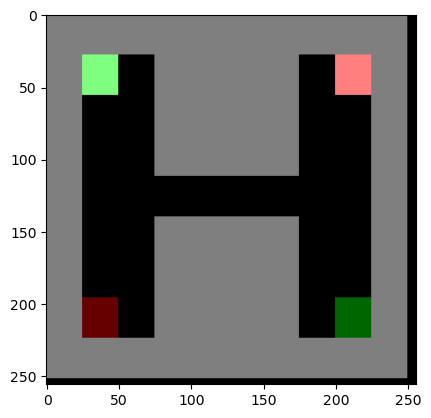

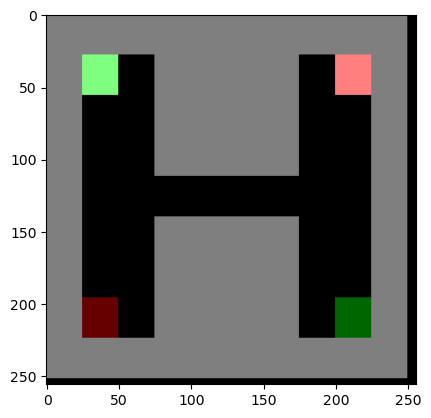

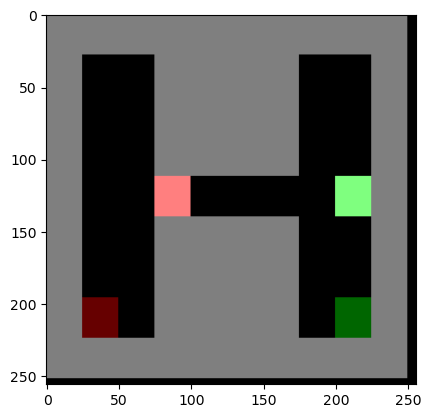

In [10]:
# Try random policy, seems to work
env.reset()
env.render()
print('State \t\t\t\t - Reward')

for i in range(1000):
    move0,move1 = env.action_space[0].sample(),env.action_space[1].sample()
    #move0=1
    #move1=1
    obs , rewards, move_completed =  env.step([move0,move1]) 

    if i%500==0: 
        print(obs,'\t\t\t',rewards)
        env.render()
    
print('Total episode reward: ', env.episode_total_reward)

## Q-learning Example

In [15]:
# Q learning params
ALPHA = 0.2 # learning rate
GAMMA = 0.95 # reward discount
LEARNING_COUNT = 2000
TEST_COUNT = 100

TURN_LIMIT = 1000
IS_MONITOR = True

class Agents:

    def __init__(self, env):
        self.env = env
        self.episode_reward_1 = 0.0
        self.episode_reward_2 = 0.0
        #remember the actions in indices 2 and 6 are the previous actions
        # need to add another dim at the end to actually select next action
        self.q_val_1 = np.zeros(9*10*5*2*9*10*5*2*5).reshape(9,10,5,2,9,10,5,2,5).astype(np.float32)
        self.q_val_2 = np.zeros(9*10*5*2*9*10*5*2*5).reshape(9,10,5,2,9,10,5,2,5).astype(np.float32)

    def update_epsilon(self,episode, total_episodes=LEARNING_COUNT, min_epsilon=0.01, max_epsilon=1.0, decay_rate=0.01):
        """
        Updates epsilon using an exponential decay formula.
        
        Parameters:
            episode (int): The current episode number.
            total_episodes (int): The total number of episodes.
            min_epsilon (float): The minimum value epsilon can take.
            max_epsilon (float): The maximum value epsilon can start from.
            decay_rate (float): The rate at which epsilon decays over time.
            
        Returns:
            float: The updated epsilon value.
        """
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
        return epsilon

    def epsilon_greedy(self,env,epsilon):
        random_numbers=np.random.rand(2)
        current_state=list(map(int,env.current_game_state))
        if random_numbers[0]<epsilon:
            act0=env.action_space[0].sample()
        else:
            act0=np.argmax(self.q_val_1[tuple(current_state)])
        
        if random_numbers[1]<epsilon:
            act1=env.action_space[1].sample()
        else:
            act1=act0=np.argmax(self.q_val_2[tuple(current_state)])

        return act0,act1


    def learn(self,epsilon):
        # one episode learning
        state = self.env.reset()

        self.episode_reward_2=0
        self.episode_reward_1=0
        state=env.current_game_state
        move_completed=[False,False]
        agent_0_has_finished=False
        agent_1_has_finished=False
        for t in range(TURN_LIMIT):

            # NEED TO CHANGE THIS SO THIS IS EPSILON GREEDY, NOT THIS RANDOM SAMPLE

            #act0,act1 = env.action_space[0].sample(),env.action_space[1].sample()
            act0,act1=self.epsilon_greedy(env,epsilon)
            next_state, rewards,move_completed=env.step([act0,act1]) 
            act0=int(act0)
            act1=int(act1)

            #act = self.env.action_space.sample() # random
            #next_state, reward, done, info = self.env.step(act, self.idx)
            assert len(next_state) == 8
            current_state=list(map(int,state))
            next_state=list(map(int,next_state))
   
            q_next_max_1=np.max(self.q_val_1[tuple(next_state)])
            q_next_max_2=np.max(self.q_val_2[tuple(next_state)])

            # Q <- Q + a(Q' - Q)
            # <=> Q <- (1-a)Q + a(Q')

            
            if not agent_0_has_finished:
                current_state_1=current_state+[act0]
                #print(current_state_1)
                self.q_val_1[tuple(current_state_1)] = (1 - ALPHA) * self.q_val_1[tuple(current_state_1)]\
                                 + ALPHA * (rewards[0] + GAMMA * q_next_max_1)
            if not agent_1_has_finished:
                current_state_2=current_state+[act1]
                self.q_val_2[tuple(current_state_2)] = (1 - ALPHA) * self.q_val_2[tuple(current_state_2)]\
                                 + ALPHA * (rewards[1] + GAMMA * q_next_max_2)
            self.episode_reward_1 += rewards[0]
            self.episode_reward_2 += rewards[1]
            #self.env.render()

            # SET FLAGS SO THAT IF AGENT HAS REACHED GOAL, Q FUNCTION WONT BE UPDATED FROM NEXT ITERAITON ONWARDS
            if move_completed[0]:
                agent_0_has_finished=True
            elif move_completed[1]:
                agent_1_has_finished=True

            if all(move_completed):
                #print(str(t+1)+" steps")
                return self.env.episode_total_reward,self.episode_reward_1,self.episode_reward_2
            else:
                state = next_state
        #print(str(t+1)+" steps")        
        return self.env.episode_total_reward,self.episode_reward_1,self.episode_reward_2

    def test(self):
        state = self.env.reset()
        for t in range(TURN_LIMIT):
            norm_coords = state[self.idx * 3]
            act = np.argmax(self.q_val[int(64.*(norm_coords+1.)/2.)])
            next_state, reward, done, info = self.env.step(act, self.idx)
            if done:
                return self.env.episode_total_reward
            else:
                state = next_state
        return 0.0 # over limit

env = GridworldEnv('')
env.reset()
agents = Agents(env)

print("###### LEARNING #####")
reward_total_1 = 0.0
reward_total_2 = 0.0
for i in range(LEARNING_COUNT):
    epsilon = agents.update_epsilon(i)
    total_reward,reward_1,reward_2=agents.learn(epsilon)
    reward_total_1 += reward_1
    reward_total_2 += reward_2
print("episodes      : {}".format(LEARNING_COUNT))
print("agent 1 total reward  : {}".format(reward_total_1))
print("agent 1 average reward: {:.2f}".format(reward_total_1 / LEARNING_COUNT))
#print("agent 1 Q Value       :{}".format(agent.q_val))
print("agent 2 total reward  : {}".format(reward_total_2))
print("agent 2 average reward: {:.2f}".format(reward_total_2 / LEARNING_COUNT))
#print("agent 2 Q Value       :{}".format(agent2.q_val))

"""
print("###### TEST #####")
reward_total_1 = 0.0
reward_total_2 = 0.0
for i in range(TEST_COUNT):
    reward_total_1 += agent1.test()
    reward_total_2 += agent2.test()
print("episodes      : {}".format(TEST_COUNT))
print("agent 1 total reward  : {}".format(reward_total_1))
print("agent 1 average reward: {:.2f}".format(reward_total_1 / TEST_COUNT))
print("agent 2 total reward  : {}".format(reward_total_2))
print("agent 2 average reward: {:.2f}".format(reward_total_2 / TEST_COUNT))
"""


/Users/samueloliveira/opt/anaconda3/envs/maai-env/lib/python3.12/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


###### LEARNING #####
episodes      : 2000
agent 1 total reward  : 37.0
agent 1 average reward: 0.02
agent 2 total reward  : 75.0
agent 2 average reward: 0.04


'\nprint("###### TEST #####")\nreward_total_1 = 0.0\nreward_total_2 = 0.0\nfor i in range(TEST_COUNT):\n    reward_total_1 += agent1.test()\n    reward_total_2 += agent2.test()\nprint("episodes      : {}".format(TEST_COUNT))\nprint("agent 1 total reward  : {}".format(reward_total_1))\nprint("agent 1 average reward: {:.2f}".format(reward_total_1 / TEST_COUNT))\nprint("agent 2 total reward  : {}".format(reward_total_2))\nprint("agent 2 average reward: {:.2f}".format(reward_total_2 / TEST_COUNT))\n'

In [17]:


Q_a1 = agents.q_val_1
Q_a1_fixed_p2=Q_a1[:,:,:,:,1,8,:,0]
Q_a1_mean=np.mean(Q_a1_fixed_p2,axis=(tuple(i for i in range(Q_a1_fixed_p2.ndim) if i != 0 and i!=1 and i!=2)))
#print(Q_a1_mean[:,:,0])
#print(Q_a1_mean[:,:,0])
policy_function1 = np.argmax(Q_a1_mean , axis = 2)

Q_a2 = agents.q_val_2 
Q_a2_mean=np.mean(Q_a2,axis=tuple(i for i in range(Q_a2.ndim) if i != 4 and i!=5 and i!=6))
policy_function2 = np.argmax( Q_a2_mean , axis = 2)
#print(policy_function1)
#print(policy_function2)

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 2 0]
 [0 2 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


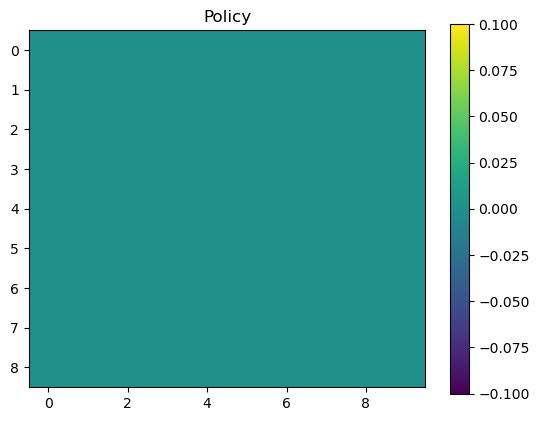

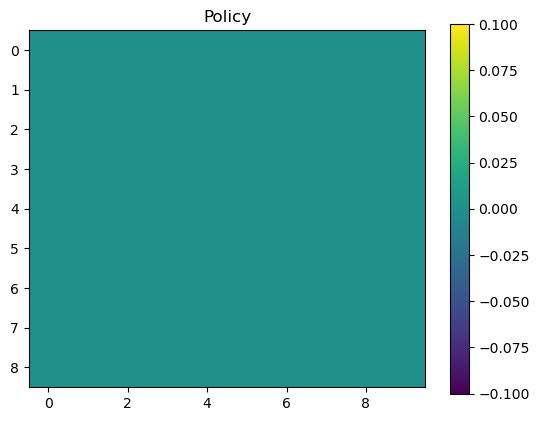

In [13]:
def plot_policy( policy_function ):

    plt.figure()
    plt.imshow( policy_function , interpolation='none' )
    plt.colorbar()

    for row in range( policy_function.shape[0] ):
        for col in range( policy_function.shape[1] ):
            if policy_function[row][col] == 0:
                continue 
            if policy_function[row][col] == 1:
                dx = 0; dy = .5
            if policy_function[row][col] == 2:
                dx = 0; dy = -.5
            if policy_function[row][col] == 3:
                dx = -.5; dy = 0
            if policy_function[row][col] == 4:
                dx = .5; dy = 0
            plt.arrow( col , row , dx , dy , shape='full', fc='w' , ec='w' , lw=3, length_includes_head=True, head_width=.2 )
    plt.title( 'Policy' )        
    plt.show() 
plot_policy(policy_function1)
plot_policy(policy_function2)

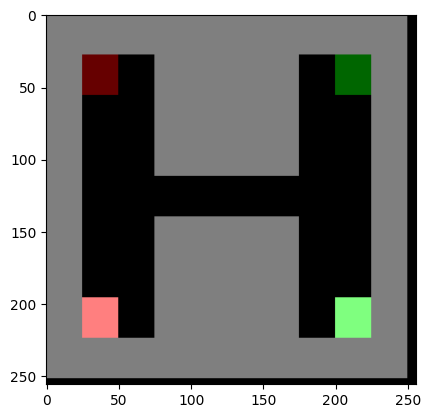

In [ ]:
env.reset()
env.render()